<a href="https://colab.research.google.com/github/world779/GCI/blob/master/DemandForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
genres = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/genres.csv")
stores = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/stores.csv")
goods = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/goods.csv")

train = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/train.csv")
test = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/test.csv")

In [ ]:
train.head()

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day
0,25-01-29,-33,43,17718,44943,2
1,25-01-08,-33,32,8648,14949,1
2,25-01-16,-33,53,10168,30158,1
3,25-01-23,-33,31,1005,9922,1
4,25-01-12,-33,27,19861,14988,0


In [ ]:
test.head()

,index,store_id,goods_id
0,0,3,15900
1,1,3,18326
2,2,3,5665
3,3,3,15859
4,4,3,8826


In [ ]:
print(train.shape)
print(test.shape)

(2882335, 6)
(214200, 3)


# 前処理  

In [ ]:
# store_id と goods_id を合わせた"id"の作成
train["id"] = "store" + train["store_id"].astype("str")
train["id"] = train["id"]+ "goods" 
train["id"] = train["id"]+ train["goods_id"].astype("str")

test["id"] = "store" + test["store_id"].astype("str")
test["id"] = test["id"]+ "goods" 
test["id"] = test["id"]+ test["goods_id"].astype("str")

In [ ]:
train.head()

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day,id
0,25-01-29,-33,43,17718,44943,2,store43goods17718
1,25-01-08,-33,32,8648,14949,1,store32goods8648
2,25-01-16,-33,53,10168,30158,1,store53goods10168
3,25-01-23,-33,31,1005,9922,1,store31goods1005
4,25-01-12,-33,27,19861,14988,0,store27goods19861


In [ ]:
test.head()

,index,store_id,goods_id,id
0,0,3,15900,store3goods15900
1,1,3,18326,store3goods18326
2,2,3,5665,store3goods5665
3,3,3,15859,store3goods15859
4,4,3,8826,store3goods8826


In [ ]:
# idごとの月々の売上の算出
id_month_sale=train.groupby(["num_month", "id"]).sum()[["units_sold_day"]].reset_index()

In [ ]:
id_month_sale.columns=['num_month', 'id', 'units_sold_month']

In [ ]:
id_month_sale.tail(10)

,num_month,id,units_sold_month
1719460,-1,store9goods4611,1
1719461,-1,store9goods5659,1
1719462,-1,store9goods6379,1
1719463,-1,store9goods6437,1
1719464,-1,store9goods7410,1
1719465,-1,store9goods7527,1
1719466,-1,store9goods7528,1
1719467,-1,store9goods7934,1
1719468,-1,store9goods8364,1
1719469,-1,store9goods8549,1


In [ ]:
test.head()

,index,store_id,goods_id,id
0,0,3,15900,store3goods15900
1,1,3,18326,store3goods18326
2,2,3,5665,store3goods5665
3,3,3,15859,store3goods15859
4,4,3,8826,store3goods8826


In [ ]:
# 予測したい月は"0"なのでnum_monthを0として追加
test["num_month"]=0

# index, goods_id, store_idは不要なので削除
del test["index"], test["goods_id"], test["store_id"], 

In [ ]:
test

,id,num_month
0,store3goods15900,0
1,store3goods18326,0
2,store3goods5665,0
3,store3goods15859,0
4,store3goods8826,0
...,...,...
214195,store60goods8851,0
214196,store60goods1539,0
214197,store60goods13719,0
214198,store60goods6074,0


# データの整形

In [ ]:
data =pd.concat([id_month_sale, test], axis=0).reset_index().iloc[:,1:]

In [ ]:
data

,num_month,id,units_sold_month,month
0,-33,store10goods10098,1.0,9
1,-33,store10goods10173,1.0,9
2,-33,store10goods1018,1.0,9
3,-33,store10goods10277,1.0,9
4,-33,store10goods10338,1.0,9
...,...,...,...,...
1933665,0,store60goods8851,NaN,0
1933666,0,store60goods1539,NaN,0
1933667,0,store60goods13719,NaN,0
1933668,0,store60goods6074,NaN,0


In [ ]:
# データが大きいので過去6ヶ月分のみ使用
#data = data[data["num_month"]>=-6]

In [ ]:
len(data)

1933670

### idごとのshift特徴量の作成  

In [ ]:
# 過去3ヶ月の売上をもとに来月の売上を予測するようなshift特徴量の作成
# trainでは-4, -3, -2の売上をもとに-1の売上を予測する
# testでは-3, -2, -1の売上をもとに0の売上を予測する  ようなイメージ
for diff in range(5):
    shift_day = 1+ diff
    print(shift_day)
    data[f"id_shift_t{shift_day}"] = data.groupby(["id"])["units_sold_month"].transform(lambda x: x.shift(shift_day))

print(f"id_shift_t{shift_day}")


1
2
3
4
5
id_shift_t5


In [ ]:
# shiiift特徴量のイメージ
data[data["id"]=="store3goods18326"]

,num_month,id,units_sold_month,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5
1719471,0,store3goods18326,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.head()

,num_month,id,units_sold_month,month,moth
0,-33,store10goods10098,1.0,9,9
1,-33,store10goods10173,1.0,9,9
2,-33,store10goods1018,1.0,9,9
3,-33,store10goods10277,1.0,9,9
4,-33,store10goods10338,1.0,9,9


In [ ]:
save=data

In [ ]:
save

,num_month,id,units_sold_month,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5
0,-33,store10goods10098,1.0,NaN,NaN,NaN,NaN,NaN
1,-33,store10goods10173,1.0,NaN,NaN,NaN,NaN,NaN
2,-33,store10goods1018,1.0,NaN,NaN,NaN,NaN,NaN
3,-33,store10goods10277,1.0,NaN,NaN,NaN,NaN,NaN
4,-33,store10goods10338,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1933665,0,store60goods8851,NaN,NaN,NaN,NaN,NaN,NaN
1933666,0,store60goods1539,NaN,2.0,6.0,NaN,NaN,NaN
1933667,0,store60goods13719,NaN,2.0,6.0,2.0,NaN,NaN
1933668,0,store60goods6074,NaN,1.0,1.0,1.0,NaN,NaN


In [ ]:
data=save

In [ ]:
data["month"]=-data["num_month"]%12

In [ ]:
data["month"] = data["month"].astype("category")
data["month"] = data["month"].astype("category")

In [ ]:
# trainとtestに分ける
train_df=data[data["num_month"]!=0]
test_df=data[data["num_month"]==0]

In [ ]:
# 欠損値埋め
train_df = train_df.fillna(0)

In [ ]:
test_df=test_df.fillna(0)

In [ ]:
train_df = train_df[train_df["num_month"]>=-28]

In [ ]:
train_df

,num_month,id,units_sold_month,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month
320307,-28,store10goods1004,1.0,0.0,0.0,0.0,0.0,0.0,4
320308,-28,store10goods11015,1.0,0.0,0.0,0.0,0.0,0.0,4
320309,-28,store10goods11504,1.0,0.0,0.0,0.0,0.0,0.0,4
320310,-28,store10goods11900,1.0,0.0,0.0,0.0,0.0,0.0,4
320311,-28,store10goods12105,1.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...
1719465,-1,store9goods7527,1.0,0.0,0.0,0.0,0.0,0.0,1
1719466,-1,store9goods7528,1.0,0.0,0.0,0.0,0.0,0.0,1
1719467,-1,store9goods7934,1.0,1.0,0.0,0.0,0.0,0.0,1
1719468,-1,store9goods8364,1.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
y=train_df["units_sold_month"]
del train_df["units_sold_month"], test_df["units_sold_month"]

In [ ]:
train_df["id"]

320307      store10goods1004
320308     store10goods11015
320309     store10goods11504
320310     store10goods11900
320311     store10goods12105
                 ...        
1719465      store9goods7527
1719466      store9goods7528
1719467      store9goods7934
1719468      store9goods8364
1719469      store9goods8549
Name: id, Length: 1399163, dtype: object

In [ ]:
train["id"]

0          store43goods17718
1           store32goods8648
2          store53goods10168
3           store31goods1005
4          store27goods19861
                 ...        
2882330    store26goods14804
2882331     store18goods7873
2882332     store57goods4562
2882333     store27goods7173
2882334    store58goods21576
Name: id, Length: 2882335, dtype: object

In [ ]:
# # idごとの月々の売上の算出
# temporary=train.groupby(["num_month", "id"]).mean()[["price"]].reset_index()
# temporary.columns=['num_month', 'id', 'price']
# temporary

,num_month,id,price
0,-33,store10goods10098,46841.0
1,-33,store10goods10173,14994.0
2,-33,store10goods1018,29604.0
3,-33,store10goods10277,10482.0
4,-33,store10goods10338,14805.0
...,...,...,...
1719465,-1,store9goods7527,34728.0
1719466,-1,store9goods7528,34826.0
1719467,-1,store9goods7934,108141.0
1719468,-1,store9goods8364,20108.0


In [ ]:
train_df

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month
320307,-28,store10goods1004,0.0,0.0,0.0,0.0,0.0,4
320308,-28,store10goods11015,0.0,0.0,0.0,0.0,0.0,4
320309,-28,store10goods11504,0.0,0.0,0.0,0.0,0.0,4
320310,-28,store10goods11900,0.0,0.0,0.0,0.0,0.0,4
320311,-28,store10goods12105,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...
1719465,-1,store9goods7527,0.0,0.0,0.0,0.0,0.0,1
1719466,-1,store9goods7528,0.0,0.0,0.0,0.0,0.0,1
1719467,-1,store9goods7934,1.0,0.0,0.0,0.0,0.0,1
1719468,-1,store9goods8364,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# train_df=pd.merge(train_df, temporary, on=['id','num_month'], how='left')
# train_df

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month,price
0,-28,store10goods1004,0.0,0.0,0.0,0.0,0.0,4,5761.0
1,-28,store10goods11015,0.0,0.0,0.0,0.0,0.0,4,9179.0
2,-28,store10goods11504,0.0,0.0,0.0,0.0,0.0,4,26447.0
3,-28,store10goods11900,0.0,0.0,0.0,0.0,0.0,4,7577.0
4,-28,store10goods12105,0.0,0.0,0.0,0.0,0.0,4,56107.0
...,...,...,...,...,...,...,...,...,...
1399158,-1,store9goods7527,0.0,0.0,0.0,0.0,0.0,1,34728.0
1399159,-1,store9goods7528,0.0,0.0,0.0,0.0,0.0,1,34826.0
1399160,-1,store9goods7934,1.0,0.0,0.0,0.0,0.0,1,108141.0
1399161,-1,store9goods8364,0.0,0.0,0.0,0.0,0.0,1,20108.0


In [ ]:
#a.isnull().sum()

In [ ]:
train_df["id"] = train_df["id"].astype("category")
test_df["id"] = test_df["id"].astype("category")


In [ ]:
# temporary=temporary.drop("num_month",axis=1)
# temporary

,id,price
0,store10goods10098,46841.0
1,store10goods10173,14994.0
2,store10goods1018,29604.0
3,store10goods10277,10482.0
4,store10goods10338,14805.0
...,...,...
1719465,store9goods7527,34728.0
1719466,store9goods7528,34826.0
1719467,store9goods7934,108141.0
1719468,store9goods8364,20108.0


In [ ]:
# tem=temporary.groupby("id").mean()[["price"]].reset_index()
# tem.columns=['id', 'price']
# tem

,id,price
0,store10goods10013,7605.0
1,store10goods1004,5777.0
2,store10goods10045,52557.0
3,store10goods10090,6726.0
4,store10goods10098,46841.0
...,...,...
503350,store9goods992,10007.0
503351,store9goods994,10074.0
503352,store9goods999,9939.0
503353,store9goods9997,29651.0


In [ ]:
# test_df=pd.merge(test_df, tem, on='id', how='left')
# test_df

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month,price
0,0,store3goods15900,1.0,2.0,0.0,0.0,0.0,0,59496.500000
1,0,store3goods18326,0.0,0.0,0.0,0.0,0.0,0,NaN
2,0,store3goods5665,1.0,1.0,2.0,2.0,1.0,0,228743.600000
3,0,store3goods15859,2.0,0.0,0.0,0.0,0.0,0,44342.500000
4,0,store3goods8826,0.0,0.0,0.0,0.0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...
214195,0,store60goods8851,0.0,0.0,0.0,0.0,0.0,0,NaN
214196,0,store60goods1539,2.0,6.0,0.0,0.0,0.0,0,50650.750000
214197,0,store60goods13719,2.0,6.0,2.0,0.0,0.0,0,21464.166667
214198,0,store60goods6074,1.0,1.0,1.0,0.0,0.0,0,119415.333333


In [ ]:
print(len(test))
print(len(test_df))

214200
214200


In [ ]:
test_df

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month,price
0,0,store3goods15900,1.0,2.0,0.0,0.0,0.0,0,59496.500000
1,0,store3goods18326,0.0,0.0,0.0,0.0,0.0,0,NaN
2,0,store3goods5665,1.0,1.0,2.0,2.0,1.0,0,228743.600000
3,0,store3goods15859,2.0,0.0,0.0,0.0,0.0,0,44342.500000
4,0,store3goods8826,0.0,0.0,0.0,0.0,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...
214195,0,store60goods8851,0.0,0.0,0.0,0.0,0.0,0,NaN
214196,0,store60goods1539,2.0,6.0,0.0,0.0,0.0,0,50650.750000
214197,0,store60goods13719,2.0,6.0,2.0,0.0,0.0,0,21464.166667
214198,0,store60goods6074,1.0,1.0,1.0,0.0,0.0,0,119415.333333


# モデル

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1399163, 9)
(214200, 9)


In [ ]:
light_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'seed': 42,
    'max_depth': 5,
    'num_leaves': 2**5,
    'learning_rate': 0.1,
    "colsample_bytree":0.7,
    "n_jobs": -1,
    "verbose": -1
}



In [ ]:
# tr_idx

0           True
1           True
2           True
3           True
4           True
           ...  
1399158    False
1399159    False
1399160    False
1399161    False
1399162    False
Name: num_month, Length: 1399163, dtype: bool

In [ ]:
len(train_df)

1399163

In [ ]:
len(y)

1399163

In [ ]:
y

320307     1.0
320308     1.0
320309     1.0
320310     1.0
320311     1.0
          ... 
1719465    1.0
1719466    1.0
1719467    1.0
1719468    1.0
1719469    1.0
Name: units_sold_month, Length: 1399163, dtype: float64

In [ ]:
tr_idx = train_df["num_month"] < -1
val_idx = train_df["num_month"] == -1

In [ ]:
train_df[tr_idx]

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month,price
0,-28,store10goods1004,0.0,0.0,0.0,0.0,0.0,4,5761.0
1,-28,store10goods11015,0.0,0.0,0.0,0.0,0.0,4,9179.0
2,-28,store10goods11504,0.0,0.0,0.0,0.0,0.0,4,26447.0
3,-28,store10goods11900,0.0,0.0,0.0,0.0,0.0,4,7577.0
4,-28,store10goods12105,0.0,0.0,0.0,0.0,0.0,4,56107.0
...,...,...,...,...,...,...,...,...,...
1366714,-2,store9goods9054,0.0,0.0,0.0,0.0,0.0,2,19901.0
1366715,-2,store9goods9356,1.0,1.0,1.0,0.0,0.0,2,35317.0
1366716,-2,store9goods9407,0.0,0.0,0.0,0.0,0.0,2,35288.0
1366717,-2,store9goods9411,0.0,0.0,0.0,0.0,0.0,2,34992.0


In [ ]:
train_df[val_idx]

,num_month,id,id_shift_t1,id_shift_t2,id_shift_t3,id_shift_t4,id_shift_t5,month,price
1366719,-1,store10goods12882,0.0,0.0,0.0,0.0,0.0,1,27153.0
1366720,-1,store10goods1468,4.0,0.0,0.0,0.0,0.0,1,86010.0
1366721,-1,store10goods14810,0.0,0.0,0.0,0.0,0.0,1,68494.0
1366722,-1,store10goods15595,0.0,0.0,0.0,0.0,0.0,1,18685.0
1366723,-1,store10goods15799,0.0,0.0,0.0,0.0,0.0,1,26482.0
...,...,...,...,...,...,...,...,...,...
1399158,-1,store9goods7527,0.0,0.0,0.0,0.0,0.0,1,34728.0
1399159,-1,store9goods7528,0.0,0.0,0.0,0.0,0.0,1,34826.0
1399160,-1,store9goods7934,1.0,0.0,0.0,0.0,0.0,1,108141.0
1399161,-1,store9goods8364,0.0,0.0,0.0,0.0,0.0,1,20108.0


In [ ]:
y[:1366719]

320307     1.0
320308     1.0
320309     1.0
320310     1.0
320311     1.0
          ... 
1687021    1.0
1687022    0.0
1687023    1.0
1687024    1.0
1687025    1.0
Name: units_sold_month, Length: 1366719, dtype: float64

In [ ]:
y[1366719:]

1687026    1.0
1687027    1.0
1687028    1.0
1687029    1.0
1687030    1.0
          ... 
1719465    1.0
1719466    1.0
1719467    1.0
1719468    1.0
1719469    1.0
Name: units_sold_month, Length: 32444, dtype: float64

In [ ]:
# バリデーション期間を-1とする
# va_period_list = [-1, -2, -3]
va_period_list = [-1]
count=0
for va_period in va_period_list:
    print(count)
    tr_idx = train_df["num_month"] < va_period
    val_idx = train_df["num_month"] == va_period 
    x_train, x_val = train_df[tr_idx], train_df[val_idx]
    y_train, y_val = y[:1366719], y[1366719:]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val, reference=train_set)
    # Training
    model = lgb.train(light_params, train_set, num_boost_round=8000, early_stopping_rounds=20,
                      valid_sets=[train_set, val_set], verbose_eval=10)
     
    test_pred = model.predict(test_df)

    oof = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, oof))
    print(f"RMSE : {rmse}")
  
print(rmse)

0


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	training's rmse: 5.3618	valid_1's rmse: 15.7406
[20]	training's rmse: 4.86474	valid_1's rmse: 15.5869
[30]	training's rmse: 4.69122	valid_1's rmse: 15.537
[40]	training's rmse: 4.60118	valid_1's rmse: 15.5178
[50]	training's rmse: 4.55708	valid_1's rmse: 15.5119
[60]	training's rmse: 4.53113	valid_1's rmse: 15.5073
[70]	training's rmse: 4.49964	valid_1's rmse: 15.5081
[80]	training's rmse: 4.47812	valid_1's rmse: 15.5081
Early stopping, best iteration is:
[60]	training's rmse: 4.53113	valid_1's rmse: 15.5073


ValueError: ignored

In [ ]:
#print(score)
3.0046788760004324

3.0046788760004324

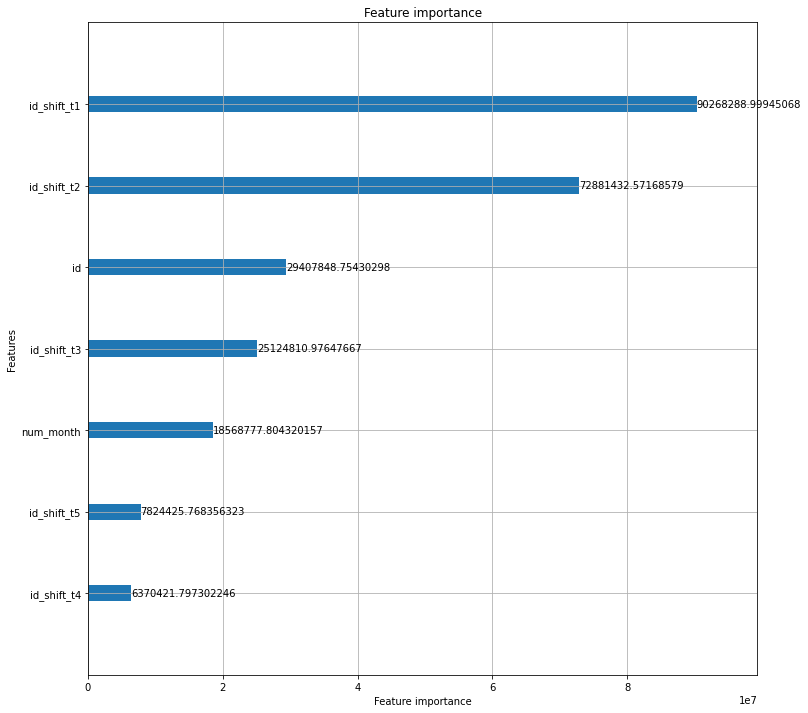

In [ ]:
lgb.plot_importance(model, importance_type="gain", max_num_features=40, figsize=(12, 12)) #max_num_features=20,

In [ ]:
sub = pd.read_csv("drive/My Drive/GCI2020summer/コンペ第3回/sample_submission.csv").iloc[:,1:]
sub["units_sold_month"] = test_pred.round(3)
sub.to_csv("drive/My Drive/GCI2020summer/コンペ第3回/baseline.csv", index=False)

In [ ]:
sub

,units_sold_month
0,1.317
1,1.916
2,1.299
3,1.627
4,1.916
...,...
214195,1.916
214196,1.933
214197,1.933
214198,1.259


In [ ]:
sub["units_sold_month"].describe()

count    214200.000000
mean          1.699590
std           1.712642
min           0.468000
25%           1.358000
50%           1.712000
75%           1.916000
max         355.736000
Name: units_sold_month, dtype: float64